## Week 13 notebook

For Week 13, include ideas such as the Bernoulli Naive Bayes, Multinomial Naive Bayes, and Gaussian Naive Bayes algorithms. Complete your Jupyter Notebook homework by 11:59pm ET on Sunday.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import feature engineering and selection libraries
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

# data preprocesing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Classification metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

# sampling methods
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)
random_state = 0

In [2]:
def encoding(df_or_series, cat_cols: list = None, one_hot: bool = False):
    """
    Encodes categorical columns in a DataFrame or a single pandas Series.

    Args:
        df_or_series: DataFrame or Series to encode.
        cat_cols: List of columns to encode (only used if input is DataFrame).
        one_hot: If True, use one-hot encoding for DataFrame input.

    Returns:
        If input is DataFrame: (encoded DataFrame, mappings dict or list of new columns)
        If input is Series: (encoded Series, mapping dict)
    """
    if isinstance(df_or_series, pd.Series):
        uniques = df_or_series.dropna().unique().tolist()
        mapping = {cat: code for code, cat in enumerate(uniques)}
        encoded = df_or_series.map(mapping).astype("int64")
        return encoded
    
    elif isinstance(df_or_series, pd.DataFrame):
        if one_hot:
            if cat_cols is None:
                cat_cols = df_or_series.select_dtypes(include=['object', 'category']).columns.tolist()
            df_encoded = pd.get_dummies(df_or_series, columns=cat_cols, drop_first=True)
            return df_encoded
        else:
            df_encoded = df_or_series.copy()
            mappings = {}
            if cat_cols is None:
                cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
            for col in cat_cols:
                uniques = df_encoded[col].dropna().unique().tolist()
                mapping = {cat: code for code, cat in enumerate(uniques)}
                mappings[col] = mapping
                df_encoded[col] = df_encoded[col].map(mapping).astype("int64")
            return df_encoded
    
    else:
        raise ValueError("Input must be a pandas DataFrame or Series.")

In [3]:
def load_and_split_data(file_path: str, target_col: str = None, one_hot: bool = False, test_size: float = 0.2, random_state: int = 0, scaling: str = None, sampling: str = None):
    """
    Loads data, encodes categorical features, splits into train/test, and scales features.

    Args:
        file_path: Path to CSV file.
        target_col: Name of target column. If None, uses last column.
        test_size: Fraction for test split.
        random_state: Random seed.
        scaling: 'norm' (MinMax), 'reg' (Standard), or None.

    Returns:
        X_train, X_test, y_train, y_test, df, mappings
    """
    df = pd.read_csv(file_path)
    
    # Select target
    if target_col is None:
        target_col = df.columns[-1]
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Encode Categorical Features
    if one_hot is True:
        X_encoded = encoding(X, one_hot=True)
        if y.dtype == 'object' or y.dtype.name == 'category':
            y_encoded = encoding(y)
        else:
            y_encoded = y
    else:
        X_encoded = encoding(X)
        if y.dtype == 'object' or y.dtype.name == 'category':
            y_encoded = encoding(y)
        else:
            y_encoded = y
            
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y_encoded, test_size=test_size, random_state=random_state
    )

     # Optional sampling (TRAIN ONLY)
    if sampling is not None:
        sampler = None
        if sampling.lower() == 'smote':
            sampler = SMOTE(random_state=random_state, sampling_strategy='auto')
        else:
            raise ValueError("sampling must be one of: None, 'smote'.")

        X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)

        # Rebuild DataFrame / Series
        X_train = pd.DataFrame(X_train_res, columns=X_train.columns)
        y_train = pd.Series(y_train_res, name=target_col)

    # Reset indices
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Scaling
    if scaling == 'reg':
        scaler = StandardScaler()
    elif scaling == 'norm':
        scaler = MinMaxScaler()
    else:
        scaler = None

    if scaler is not None:
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    return X_train, X_test, y_train, y_test, df


In [ ]:
X_train_ins_base, X_test_ins_base, y_train_ins_base, y_test_ins_base, ins_base_df = load_and_split_data(
    file_path=r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\data\insurance_claims_cleaned.csv',
    target_col='fraud_reported', scaling=None)

X_train_ins_norm, X_test_ins_norm, y_train_ins_norm, y_test_ins_norm, ins_norm_df = load_and_split_data(
    file_path=r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\data\insurance_claims_cleaned.csv',
    target_col='fraud_reported', scaling='norm')


In [5]:
# Resampled datasets
X_train_ins_base_s, X_test_ins_base_s, y_train_ins_base_s, y_test_ins_base_s, ins_base_df_s = load_and_split_data(
    file_path=r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\data\insurance_claims_cleaned.csv',
    target_col='fraud_reported', scaling=None, sampling='smote')

X_train_ins_norm_s, X_test_ins_norm_s, y_train_ins_norm_s, y_test_ins_norm_s, ins_norm_df_s = load_and_split_data(
    file_path=r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\data\insurance_claims_cleaned.csv',
    target_col='fraud_reported', scaling='norm', sampling='smote')

In [6]:
def gridsearchcv(model, X_train, y_train=None, param_dict=None, random_state=random_state, scoring='accuracy', cv=None):
    """
    Generic grid search function for any sklearn model and parameter grid.

    Args:
        model: The sklearn model class (not an instance), e.g., SVC, RandomForestClassifier, etc.
        X_train: Training features.
        y_train: Training target.
        param_dict: Dictionary of parameter grid for the model.
        random_state: Random state for reproducibility.
        scoring: Scoring metric for GridSearchCV.
        cv: Cross-validation strategy (optional).

    Returns:
        grid_best_params: Best parameter dictionary.
        grid_cv_score: Best cross-validated score.
    """
    # If the model supports random_state, pass it; otherwise, ignore
    try:
        base_model = model(random_state=random_state)
    except TypeError:
        base_model = model()

    # Use provided cv or default to RepeatedStratifiedKFold for classification
    if cv is None:
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_state)

    search = GridSearchCV(
        estimator=base_model,
        param_grid=param_dict,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        return_train_score=True,
        error_score='raise'
    )

    search.fit(X_train, y_train)

    # Extract results into a DataFrame
    results = pd.DataFrame(search.cv_results_)

    # Print top 5 results (show all param columns dynamically)
    param_cols = [col for col in results.columns if col.startswith('param_')]
    display_cols = param_cols + [
        'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'rank_test_score'
    ]
    results = results[display_cols].sort_values(by='rank_test_score')
    renamed_results = results.rename(
        columns={col: col.replace('param_', '') for col in param_cols} |
                {'mean_test_score': 'mean_cv_score', 'std_test_score': 'std_cv_score'}
    ).drop(columns=['rank_test_score'])

    print("\nSearch Results (Top 5):\n")
    print(renamed_results.head(5).to_string(index=False))

    # Best parameters and test performance
    grid_best_params = search.best_params_
    print(f"\nBest Parameters: {grid_best_params}")
    grid_cv_score = search.best_score_
    print(f"Best CV Score: {grid_cv_score:.4f}")

    return grid_best_params, grid_cv_score

In [7]:
def classifier_model(data_used, model_class, X_train, y_train, X_test, y_test, **model_params):
    """
    Generic function to fit and evaluate any sklearn classifier model.

    Args:
        data_used: String indicating the dataset used (for logging purposes).
        model_class: The sklearn classifier class (e.g., RandomForestClassifier, DecisionTreeClassifier).
        X_train, y_train: Training data.
        X_test, y_test: Test data.
        model_params: Parameters for the classifier.

    Prints:
        Classification report, accuracy, F1 score, and confusion matrix plot.

    Returns:
        model: The fitted model.
        y_pred: The predictions on X_test.
        results: Dictionary of results for later analysis.
    """
    model = model_class(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    clf_name = model_class.__name__

    # Print the classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f"Classification Report for {clf_name} with {data_used}:")
    print(classification_report(y_test, y_pred, output_dict=False))
    print("\n")

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{clf_name} Accuracy: {accuracy:.2f}")
    
    # Calculate f1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{clf_name} F1 score: {f1:.2f}")
    
    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {clf_name} with {data_used}')
    plt.tight_layout()
    plt.show()

    # Save results for later analysis
    results = {
        'data_used': data_used,
        'model_name': clf_name,
        'model_params': model.get_params(),
        'accuracy': accuracy,
        'f1_score': f1
    }

    return model, y_pred, results

### Bernoulli Naive Bayes


Search Results (Top 5):

 alpha  mean_cv_score  std_cv_score  mean_train_score  std_train_score
   0.7        0.80500      0.024495          0.818812         0.007036
   0.8        0.80500      0.023848          0.818500         0.006741
   0.5        0.80475      0.024955          0.819063         0.006847
   0.6        0.80475      0.025080          0.818875         0.007301
   0.1        0.80450      0.025527          0.819688         0.007289

Best Parameters: {'alpha': np.float64(0.7000000000000001)}
Best CV Score: 0.8050

Classification Report for BernoulliNB with Bernoulli base insurance claims dataset:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       143
           1       0.66      0.47      0.55        57

    accuracy                           0.78       200
   macro avg       0.73      0.69      0.70       200
weighted avg       0.77      0.78      0.77       200



BernoulliNB Accuracy: 0.78
BernoulliNB F1 score: 0.7

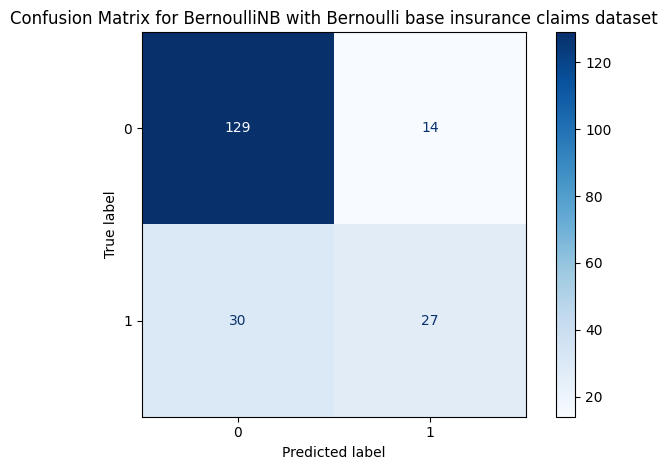

In [8]:
# Gridsearch parameters for the Bernoulli NB model
param_grid_bnb_base = {
    'alpha': np.linspace(0.1, 1.0, 10)
}

grid_best_params_nb_base, grid_cv_score_bnb_base = gridsearchcv(
    BernoulliNB,X_train_ins_base, y_train_ins_base, param_dict=param_grid_bnb_base, random_state=random_state, scoring='accuracy', cv=None)

print()

# Evaluate the bnb reg model
base_ins_bnb_model, base_ins_bnb_pred, base_ins_bnb_results = classifier_model(
    "Bernoulli base insurance claims dataset",
    BernoulliNB,
    X_train_ins_base,
    y_train_ins_base,
    X_test_ins_base,
    y_test_ins_base,
    **grid_best_params_nb_base
)


Search Results (Top 5):

 alpha  mean_cv_score  std_cv_score  mean_train_score  std_train_score
   1.0       0.793934      0.021010          0.800738         0.005731
   0.7       0.793607      0.021054          0.800861         0.005751
   0.9       0.793607      0.021054          0.800820         0.005686
   0.8       0.793607      0.021054          0.800861         0.005751
   0.5       0.793443      0.021185          0.800738         0.005804

Best Parameters: {'alpha': np.float64(1.0)}
Best CV Score: 0.7939

Classification Report for BernoulliNB with Bernoulli SMOTE base insurance claims dataset:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       143
           1       0.58      0.67      0.62        57

    accuracy                           0.77       200
   macro avg       0.72      0.74      0.73       200
weighted avg       0.78      0.77      0.77       200



BernoulliNB Accuracy: 0.77
BernoulliNB F1 score: 0.77


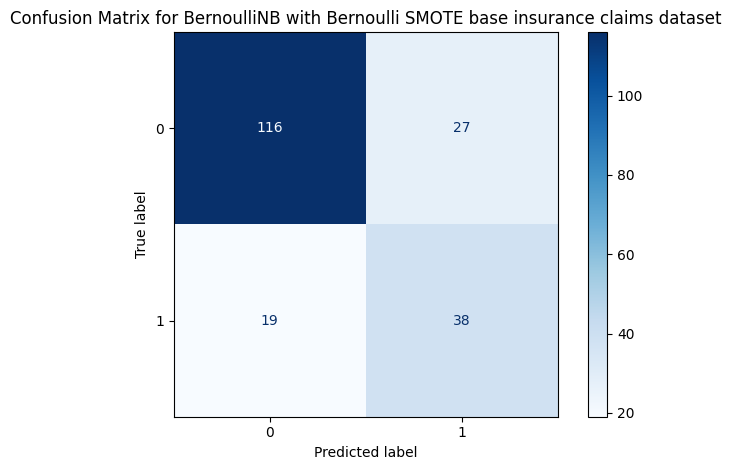

In [9]:
# Run with resampled data
# Gridsearch parameters for the Bernoulli NB model
param_grid_bnb_base_s = {
    'alpha': np.linspace(0.1, 1.0, 10)
}

grid_best_params_nb_base_s, grid_cv_score_bnb_base_s = gridsearchcv(
    BernoulliNB,X_train_ins_base_s, y_train_ins_base_s, param_dict=param_grid_bnb_base_s, random_state=random_state, scoring='accuracy', cv=None)

print()

# Evaluate the bnb reg model
base_ins_bnb_model_s, base_ins_bnb_pred_s, base_ins_bnb_results_s = classifier_model(
    "Bernoulli SMOTE base insurance claims dataset",
    BernoulliNB,
    X_train_ins_base_s,
    y_train_ins_base_s,
    X_test_ins_base_s,
    y_test_ins_base_s,
    **grid_best_params_nb_base_s
)

### Gaussian Naive Bayes


Search Results (Top 5):

 var_smoothing  mean_cv_score  std_cv_score  mean_train_score  std_train_score
  1.000000e-04        0.75700      0.011901          0.758437         0.004980
  1.000000e-05        0.74125      0.018200          0.748812         0.005436
  1.000000e-06        0.70075      0.032226          0.714563         0.014140
  1.000000e-08        0.69025      0.026639          0.707625         0.014943
  1.000000e-07        0.68625      0.032930          0.704000         0.015669

Best Parameters: {'var_smoothing': 0.0001}
Best CV Score: 0.7570

Classification Report for GaussianNB with Gaussian base insurance claims dataset:
              precision    recall  f1-score   support

           0       0.71      0.95      0.81       143
           1       0.22      0.04      0.06        57

    accuracy                           0.69       200
   macro avg       0.47      0.49      0.44       200
weighted avg       0.57      0.69      0.60       200



GaussianNB Accuracy: 0

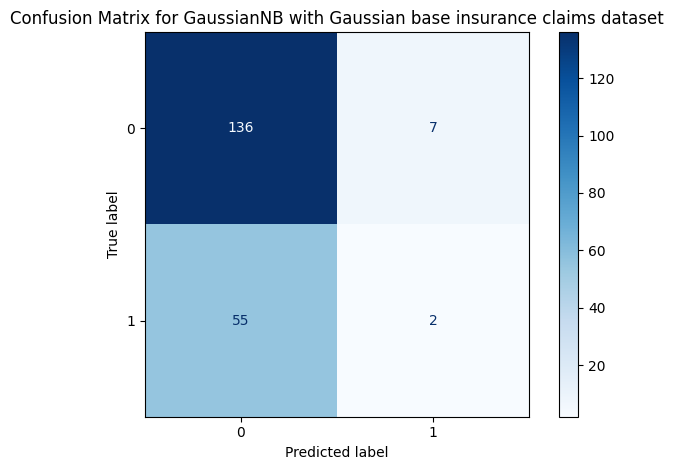

In [10]:
# Gridsearch parameters for the Gaussian NB model
param_grid_gnb_base = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
}

grid_best_params_gnb_base, grid_cv_score_gnb_base = gridsearchcv(
    GaussianNB,X_train_ins_base, y_train_ins_base, param_dict=param_grid_gnb_base, random_state=random_state, scoring='accuracy', cv=None)

print()

# Evaluate the gnb base model
base_ins_gnb_model, base_ins_gnb_pred, base_ins_gnb_results = classifier_model(
    "Gaussian base insurance claims dataset",
    GaussianNB,
    X_train_ins_base,
    y_train_ins_base,
    X_test_ins_base,
    y_test_ins_base,
    **grid_best_params_gnb_base
)


Search Results (Top 5):

 var_smoothing  mean_cv_score  std_cv_score  mean_train_score  std_train_score
  1.000000e-09       0.611148      0.021696          0.617295         0.006723
  1.000000e-06       0.609016      0.019943          0.612459         0.004980
  1.000000e-07       0.608033      0.020990          0.612582         0.005777
  1.000000e-05       0.608033      0.020074          0.613074         0.004883
  1.000000e-08       0.606721      0.021421          0.612869         0.006173

Best Parameters: {'var_smoothing': 1e-09}
Best CV Score: 0.6111

Classification Report for GaussianNB with Gaussian SMOTE base insurance claims dataset:
              precision    recall  f1-score   support

           0       0.81      0.38      0.51       143
           1       0.33      0.77      0.46        57

    accuracy                           0.49       200
   macro avg       0.57      0.57      0.49       200
weighted avg       0.67      0.49      0.50       200



GaussianNB Accura

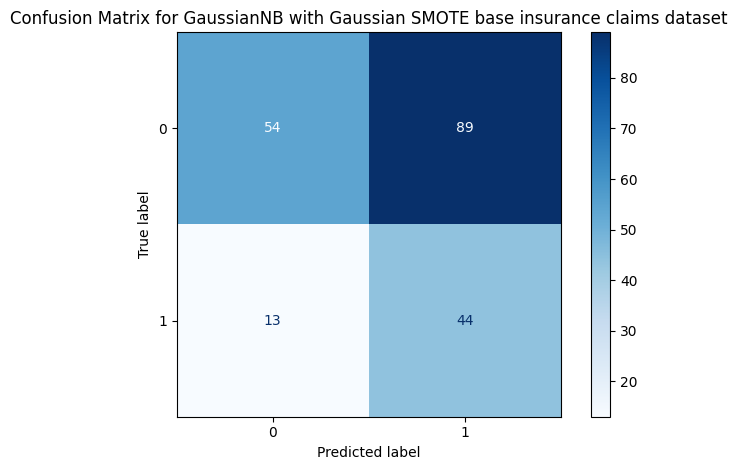

In [11]:
# Gridsearch parameters for the Gaussian NB model
param_grid_gnb_base_s = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
}

grid_best_params_gnb_base_s, grid_cv_score_gnb_base_s = gridsearchcv(
    GaussianNB,X_train_ins_base_s, y_train_ins_base_s, param_dict=param_grid_gnb_base_s, random_state=random_state, scoring='accuracy', cv=None)

print()

# Evaluate the gnb base model
base_ins_gnb_model_s, base_ins_gnb_pred_s, base_ins_gnb_results_s = classifier_model(
    "Gaussian SMOTE base insurance claims dataset",
    GaussianNB,
    X_train_ins_base_s,
    y_train_ins_base_s,
    X_test_ins_base_s,
    y_test_ins_base_s,
    **grid_best_params_gnb_base_s
)

### Multinomial Naive Bayes


Search Results (Top 5):

 alpha  mean_cv_score  std_cv_score  mean_train_score  std_train_score
   0.1         0.7625  1.110223e-16            0.7625     1.110223e-16
   0.2         0.7625  1.110223e-16            0.7625     1.110223e-16
   0.3         0.7625  1.110223e-16            0.7625     1.110223e-16
   0.4         0.7625  1.110223e-16            0.7625     1.110223e-16
   0.5         0.7625  1.110223e-16            0.7625     1.110223e-16

Best Parameters: {'alpha': np.float64(0.1)}
Best CV Score: 0.7625

Classification Report for MultinomialNB with Multinomial normalized insurance claims dataset:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       143
           1       0.00      0.00      0.00        57

    accuracy                           0.71       200
   macro avg       0.36      0.50      0.42       200
weighted avg       0.51      0.71      0.60       200



MultinomialNB Accuracy: 0.71
MultinomialNB F1 score: 0.60

c:\Users\JT von Seggern\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\JT von Seggern\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\JT von Seggern\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

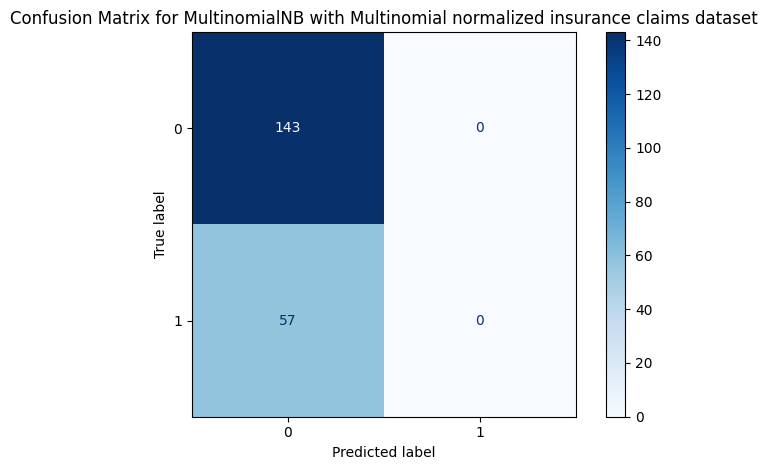

In [12]:
# Gridsearch parameters for the Multinomial NB model
param_grid_mnb_base = {
    'alpha': np.linspace(0.1, 1.0, 10)
}

grid_best_params_mnb_base, grid_cv_score_mnb_base = gridsearchcv(
    MultinomialNB,X_train_ins_norm, y_train_ins_norm, param_dict=param_grid_mnb_base, random_state=random_state, scoring='accuracy', cv=None)

print()

# Evaluate the mnb base model
base_ins_mnb_model, base_ins_mnb_pred, base_ins_mnb_results = classifier_model(
    "Multinomial normalized insurance claims dataset",
    MultinomialNB,
    X_train_ins_norm,
    y_train_ins_norm,
    X_test_ins_norm,
    y_test_ins_norm,
    **grid_best_params_mnb_base
)


Search Results (Top 5):

 alpha  mean_cv_score  std_cv_score  mean_train_score  std_train_score
   0.1       0.781475      0.022618          0.793852         0.008354
   0.2       0.781475      0.022499          0.793893         0.008373
   0.3       0.781475      0.022409          0.793770         0.008347
   0.6       0.781475      0.022678          0.793566         0.008329
   0.7       0.781311      0.022889          0.793566         0.008329

Best Parameters: {'alpha': np.float64(0.1)}
Best CV Score: 0.7815

Classification Report for MultinomialNB with Multinomial SMOTE normalized insurance claims dataset:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       143
           1       0.49      0.54      0.52        57

    accuracy                           0.71       200
   macro avg       0.65      0.66      0.65       200
weighted avg       0.72      0.71      0.71       200



MultinomialNB Accuracy: 0.71
MultinomialNB F1 score

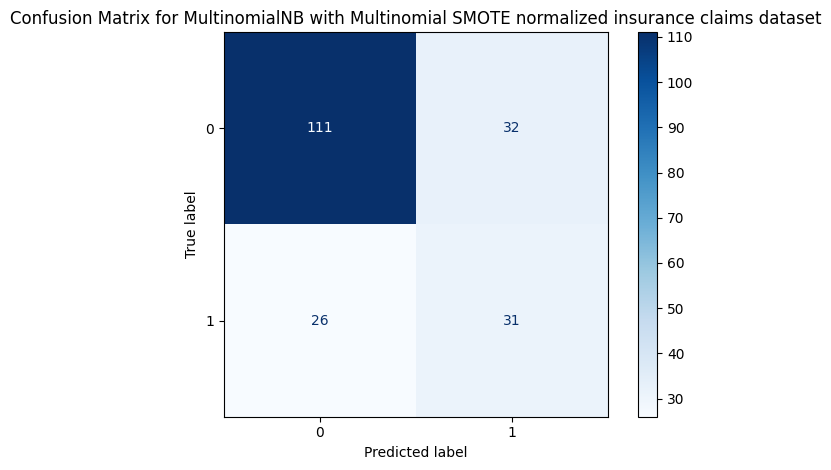

In [13]:
# Gridsearch parameters for the Multinomial NB model
param_grid_mnb_base_s = {
    'alpha': np.linspace(0.1, 1.0, 10)
}

grid_best_params_mnb_base_s, grid_cv_score_mnb_base_s = gridsearchcv(
    MultinomialNB,X_train_ins_norm_s, y_train_ins_norm_s, param_dict=param_grid_mnb_base_s, random_state=random_state, scoring='accuracy', cv=None)

print()

# Evaluate the mnb base model
base_ins_mnb_model_s, base_ins_mnb_pred_s, base_ins_mnb_results_s = classifier_model(
    "Multinomial SMOTE normalized insurance claims dataset",
    MultinomialNB,
    X_train_ins_norm_s,
    y_train_ins_norm_s,
    X_test_ins_norm_s,
    y_test_ins_norm_s,
    **grid_best_params_mnb_base_s
)

In [20]:
# Print the results in a dataframe for comparison
results_all = pd.DataFrame({
    "Gaussian NB": base_ins_gnb_results,
    "Bernoulli NB": base_ins_bnb_results,
    "Multinomial NB": base_ins_mnb_results,
    "Gaussian SMOTE NB": base_ins_gnb_results_s,
    "Bernoulli SMOTE NB": base_ins_bnb_results_s,
    "Multinomial SMOTE NB": base_ins_mnb_results_s
})

print("\nSummary of All Model Results:\n")
results_all


Summary of All Model Results:



,Gaussian NB,Bernoulli NB,Multinomial NB,Gaussian SMOTE NB,Bernoulli SMOTE NB,Multinomial SMOTE NB
data_used,Gaussian base insurance claims dataset,Bernoulli base insurance claims dataset,Multinomial normalized insurance claims dataset,Gaussian SMOTE base insurance claims dataset,Bernoulli SMOTE base insurance claims dataset,Multinomial SMOTE normalized insurance claims ...
model_name,GaussianNB,BernoulliNB,MultinomialNB,GaussianNB,BernoulliNB,MultinomialNB
model_params,"{'priors': None, 'var_smoothing': 0.0001}","{'alpha': 0.7000000000000001, 'binarize': 0.0,...","{'alpha': 0.1, 'class_prior': None, 'fit_prior...","{'priors': None, 'var_smoothing': 1e-09}","{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...","{'alpha': 0.1, 'class_prior': None, 'fit_prior..."
accuracy,0.69,0.78,0.715,0.49,0.77,0.71
f1_score,0.599548,0.767869,0.596181,0.499714,0.774232,0.714143
